# Somnai's SuperRes Diffusion: Batch Upscaling & Super Resolution with Latent-Diffusion.



Built on top of Latent-Diffusion (https://github.com/CompVis/latent-diffusion) and their preview notebook (https://colab.research.google.com/drive/1xqzUi2iXQXDqXBHQGP9Mqt2YrYW6cx-J?usp=sharing#scrollTo=uXkBaR3-nlMZ)

-

By Somnai (https://twitter.com/somnai_dreams).

-

TODO:

*   Expose more functions and variables (e.g. custom upscaling ratios, eta)
*   Normalise size option
*   Custom scaling

-

Changelog: 

Fix for non-RGB images, exposed ETA settings, added downscaling algorithm choice.

# Setup

In [ ]:
!nvidia-smi -L

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Install

In [1]:
#@title Clone repos and install requirements
#%cd '/content'
# !git clone https://github.com/CompVis/latent-diffusion.git
# !git clone https://github.com/CompVis/taming-transformers
#!pip install -e ./taming-transformers
#!pip install ipywidgets omegaconf>=2.0.0 pytorch-lightning>=1.0.8 torch-fidelity einops

import sys
import ipywidgets as widgets
import os
import gc
from IPython import display
sys.path.append(".")
sys.path.append('../taming_transformers')
sys.path.append('./latent_diffusion')
#from clip_generators.models.upscaler.taming_transformers.taming.models import vqgan # checking correct import from taming
from torchvision.datasets.utils import download_url
#%cd '/content/latent-diffusion'
from clip_generators.models.upscaler.latent_diffusion.ldm.util import instantiate_from_config
from clip_generators.models.upscaler.latent_diffusion.ldm.models.diffusion.ddim import DDIMSampler
from clip_generators.models.upscaler.latent_diffusion.ldm.util import ismap
#%cd '/content'
import torch
#from google.colab import files
from IPython.display import Image as ipyimg
import ipywidgets as widgets
from PIL import Image
from numpy import asarray
from einops import rearrange, repeat
import torch, torchvision
import time
from omegaconf import OmegaConf
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
#@title Define stuff


def download_models(mode):

    if mode == "superresolution":
        # this is the small bsr light model
        url_conf = 'https://heibox.uni-heidelberg.de/f/31a76b13ea27482981b4/?dl=1'
        url_ckpt = 'https://heibox.uni-heidelberg.de/f/578df07c8fc04ffbadf3/?dl=1'

        path_conf = 'logs/diffusion/superresolution_bsr/configs/project.yaml'
        path_ckpt = 'logs/diffusion/superresolution_bsr/checkpoints/last.ckpt'

        download_url(url_conf, path_conf)
        download_url(url_ckpt, path_ckpt)

        path_conf = path_conf + '/?dl=1' # fix it
        path_ckpt = path_ckpt + '/?dl=1' # fix it
        return path_conf, path_ckpt

    else:
        raise NotImplementedError


def load_model_from_config(config, ckpt):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    global_step = pl_sd["global_step"]
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.cuda()
    model.eval()
    return {"model": model}, global_step


def get_model(mode):
    path_conf, path_ckpt = download_models(mode)
    config = OmegaConf.load(path_conf)
    model, step = load_model_from_config(config, path_ckpt)
    return model


def get_custom_cond(mode):
    dest = "data/example_conditioning"

    if mode == "superresolution":
        uploaded_img = files.upload()
        filename = next(iter(uploaded_img))
        name, filetype = filename.split(".") # todo assumes just one dot in name !
        os.rename(f"{filename}", f"{dest}/{mode}/custom_{name}.{filetype}")

    elif mode == "text_conditional":
        w = widgets.Text(value='A cake with cream!', disabled=True)
        display.display(w)

        with open(f"{dest}/{mode}/custom_{w.value[:20]}.txt", 'w') as f:
            f.write(w.value)

    elif mode == "class_conditional":
        w = widgets.IntSlider(min=0, max=1000)
        display.display(w)
        with open(f"{dest}/{mode}/custom.txt", 'w') as f:
            f.write(w.value)

    else:
        raise NotImplementedError(f"cond not implemented for mode{mode}")


def get_cond_options(mode):
    path = "data/example_conditioning"
    path = os.path.join(path, mode)
    onlyfiles = [f for f in sorted(os.listdir(path))]
    return path, onlyfiles


def select_cond_path(mode):
    path = "data/example_conditioning"  # todo
    path = os.path.join(path, mode)
    onlyfiles = [f for f in sorted(os.listdir(path))]

    selected = widgets.RadioButtons(
        options=onlyfiles,
        description='Select conditioning:',
        disabled=False
    )
    display.display(selected)
    selected_path = os.path.join(path, selected.value)
    return selected_path


def get_cond(mode, selected_path):
    example = dict()
    if mode == "superresolution":
        up_f = 4
        visualize_cond_img(selected_path)

        c = Image.open(selected_path).convert('RGB')
        c = torch.unsqueeze(torchvision.transforms.ToTensor()(c), 0)
        c_up = torchvision.transforms.functional.resize(c, size=[up_f * c.shape[2], up_f * c.shape[3]], antialias=True)
        c_up = rearrange(c_up, '1 c h w -> 1 h w c')
        c = rearrange(c, '1 c h w -> 1 h w c')
        c = 2. * c - 1.

        c = c.to(torch.device("cuda"))
        example["LR_image"] = c
        example["image"] = c_up

    return example


def visualize_cond_img(path):
    display.display(ipyimg(filename=path))


def run(model, selected_path, task, custom_steps, eta, resize_enabled=False, classifier_ckpt=None, global_step=None):
    # global stride

    example = get_cond(task, selected_path)

    save_intermediate_vid = False
    n_runs = 1
    masked = False
    guider = None
    ckwargs = None
    mode = 'ddim'
    ddim_use_x0_pred = False
    temperature = 1.
    eta = eta
    make_progrow = True
    custom_shape = None

    height, width = example["image"].shape[1:3]
    split_input = height >= 128 and width >= 128

    if split_input:
        ks = 128
        stride = 64
        vqf = 4  #
        model.split_input_params = {"ks": (ks, ks), "stride": (stride, stride),
                                    "vqf": vqf,
                                    "patch_distributed_vq": True,
                                    "tie_braker": False,
                                    "clip_max_weight": 0.5,
                                    "clip_min_weight": 0.01,
                                    "clip_max_tie_weight": 0.5,
                                    "clip_min_tie_weight": 0.01}
    else:
        if hasattr(model, "split_input_params"):
            delattr(model, "split_input_params")

    invert_mask = False

    x_T = None
    for n in range(n_runs):
        if custom_shape is not None:
            x_T = torch.randn(1, custom_shape[1], custom_shape[2], custom_shape[3]).to(model.device)
            x_T = repeat(x_T, '1 c h w -> b c h w', b=custom_shape[0])

        logs = make_convolutional_sample(example, model,
                                         mode=mode, custom_steps=custom_steps,
                                         eta=eta, swap_mode=False , masked=masked,
                                         invert_mask=invert_mask, quantize_x0=False,
                                         custom_schedule=None, decode_interval=10,
                                         resize_enabled=resize_enabled, custom_shape=custom_shape,
                                         temperature=temperature, noise_dropout=0.,
                                         corrector=guider, corrector_kwargs=ckwargs, x_T=x_T, save_intermediate_vid=save_intermediate_vid,
                                         make_progrow=make_progrow,ddim_use_x0_pred=ddim_use_x0_pred
                                         )
    return logs


@torch.no_grad()
def convsample_ddim(model, cond, steps, shape, eta=1.0, callback=None, normals_sequence=None,
                    mask=None, x0=None, quantize_x0=False, img_callback=None,
                    temperature=1., noise_dropout=0., score_corrector=None,
                    corrector_kwargs=None, x_T=None, log_every_t=None
                    ):

    ddim = DDIMSampler(model)
    bs = shape[0]  # dont know where this comes from but wayne
    shape = shape[1:]  # cut batch dim
    print(f"Sampling with eta = {eta}; steps: {steps}")
    samples, intermediates = ddim.sample(steps, batch_size=bs, shape=shape, conditioning=cond, callback=callback,
                                         normals_sequence=normals_sequence, quantize_x0=quantize_x0, eta=eta,
                                         mask=mask, x0=x0, temperature=temperature, verbose=False,
                                         score_corrector=score_corrector,
                                         corrector_kwargs=corrector_kwargs, x_T=x_T)

    return samples, intermediates


@torch.no_grad()
def make_convolutional_sample(batch, model, mode="vanilla", custom_steps=None, eta=1.0, swap_mode=False, masked=False,
                              invert_mask=True, quantize_x0=False, custom_schedule=None, decode_interval=1000,
                              resize_enabled=False, custom_shape=None, temperature=1., noise_dropout=0., corrector=None,
                              corrector_kwargs=None, x_T=None, save_intermediate_vid=False, make_progrow=True,ddim_use_x0_pred=False):
    log = dict()

    z, c, x, xrec, xc = model.get_input(batch, model.first_stage_key,
                                        return_first_stage_outputs=True,
                                        force_c_encode=not (hasattr(model, 'split_input_params')
                                                            and model.cond_stage_key == 'coordinates_bbox'),
                                        return_original_cond=True)

    log_every_t = 1 if save_intermediate_vid else None

    if custom_shape is not None:
        z = torch.randn(custom_shape)
        # print(f"Generating {custom_shape[0]} samples of shape {custom_shape[1:]}")

    z0 = None

    log["input"] = x
    log["reconstruction"] = xrec

    if ismap(xc):
        log["original_conditioning"] = model.to_rgb(xc)
        if hasattr(model, 'cond_stage_key'):
            log[model.cond_stage_key] = model.to_rgb(xc)

    else:
        log["original_conditioning"] = xc if xc is not None else torch.zeros_like(x)
        if model.cond_stage_model:
            log[model.cond_stage_key] = xc if xc is not None else torch.zeros_like(x)
            if model.cond_stage_key =='class_label':
                log[model.cond_stage_key] = xc[model.cond_stage_key]

    with model.ema_scope("Plotting"):
        t0 = time.time()
        img_cb = None

        sample, intermediates = convsample_ddim(model, c, steps=custom_steps, shape=z.shape,
                                                eta=eta,
                                                quantize_x0=quantize_x0, img_callback=img_cb, mask=None, x0=z0,
                                                temperature=temperature, noise_dropout=noise_dropout,
                                                score_corrector=corrector, corrector_kwargs=corrector_kwargs,
                                                x_T=x_T, log_every_t=log_every_t)
        t1 = time.time()

        if ddim_use_x0_pred:
            sample = intermediates['pred_x0'][-1]

    x_sample = model.decode_first_stage(sample)

    try:
        x_sample_noquant = model.decode_first_stage(sample, force_not_quantize=True)
        log["sample_noquant"] = x_sample_noquant
        log["sample_diff"] = torch.abs(x_sample_noquant - x_sample)
    except:
        pass

    log["sample"] = x_sample
    log["time"] = t1 - t0

    return log

In [4]:
#@title Download checkp and load model
diffMode = 'superresolution'
model = get_model('superresolution')

Using downloaded and verified file: logs/diffusion/superresolution_bsr/configs/project.yaml/?dl=1
Using downloaded and verified file: logs/diffusion/superresolution_bsr/checkpoints/last.ckpt/?dl=1
Loading model from logs/diffusion/superresolution_bsr/checkpoints/last.ckpt/?dl=1
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 113.62 M params.
Keeping EMAs of 308.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


# Settings

In [5]:
#@title Run settings

diffusion_steps = "100" #@param [25, 50, 100, 250, 500, 1000]
diffusion_steps = int(diffusion_steps)
eta = 1.0 #@param  {type: 'raw'}
stride = 0 #not working atm

#@markdown ####Scaling options:
#@markdown Downsampling to 256px first will often improve the final image and runs faster.
#@markdown 
#@markdown You can improve sharpness without upscaling by upscaling and then downsampling to the original size (i.e. Super Resolution)
pre_downsample = 'None' #@param ['None', '1/2', '1/4']

post_downsample = 'None' #@param ['None', 'Original Size', '1/2', '1/4']

#@markdown Nearest gives sharper results, but may look more pixellated. Lancoz is much higher quality, but result may be less crisp.
downsample_method = 'Lanczos' #@param ['Nearest', 'Lanczos']

#Run

Running /home/lleonard/dev/perso/clip_generators/clip_generators/bots/res/discord_out_diffusion/2022_01_05/2022-01-05T01:52:13.403241_Malka#9644_The tarot card of Moon. Art Deco style./out.png


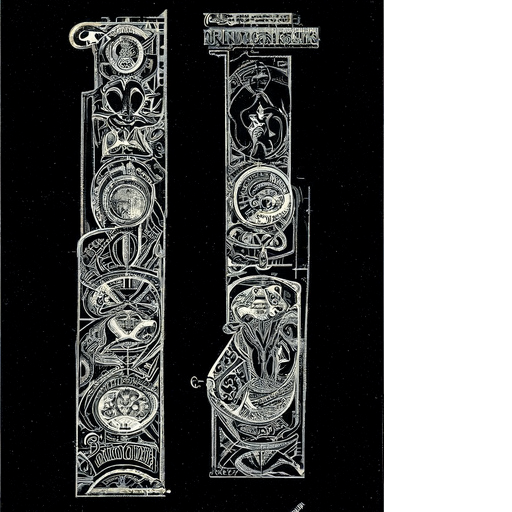

Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 100
Data shape for DDIM sampling is (1, 3, 512, 512), eta 1.0
Running DDIM Sampling with 100 timesteps


DDIM Sampler: 100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


Plotting: Restored training weights
(1, 2048, 2048, 3)


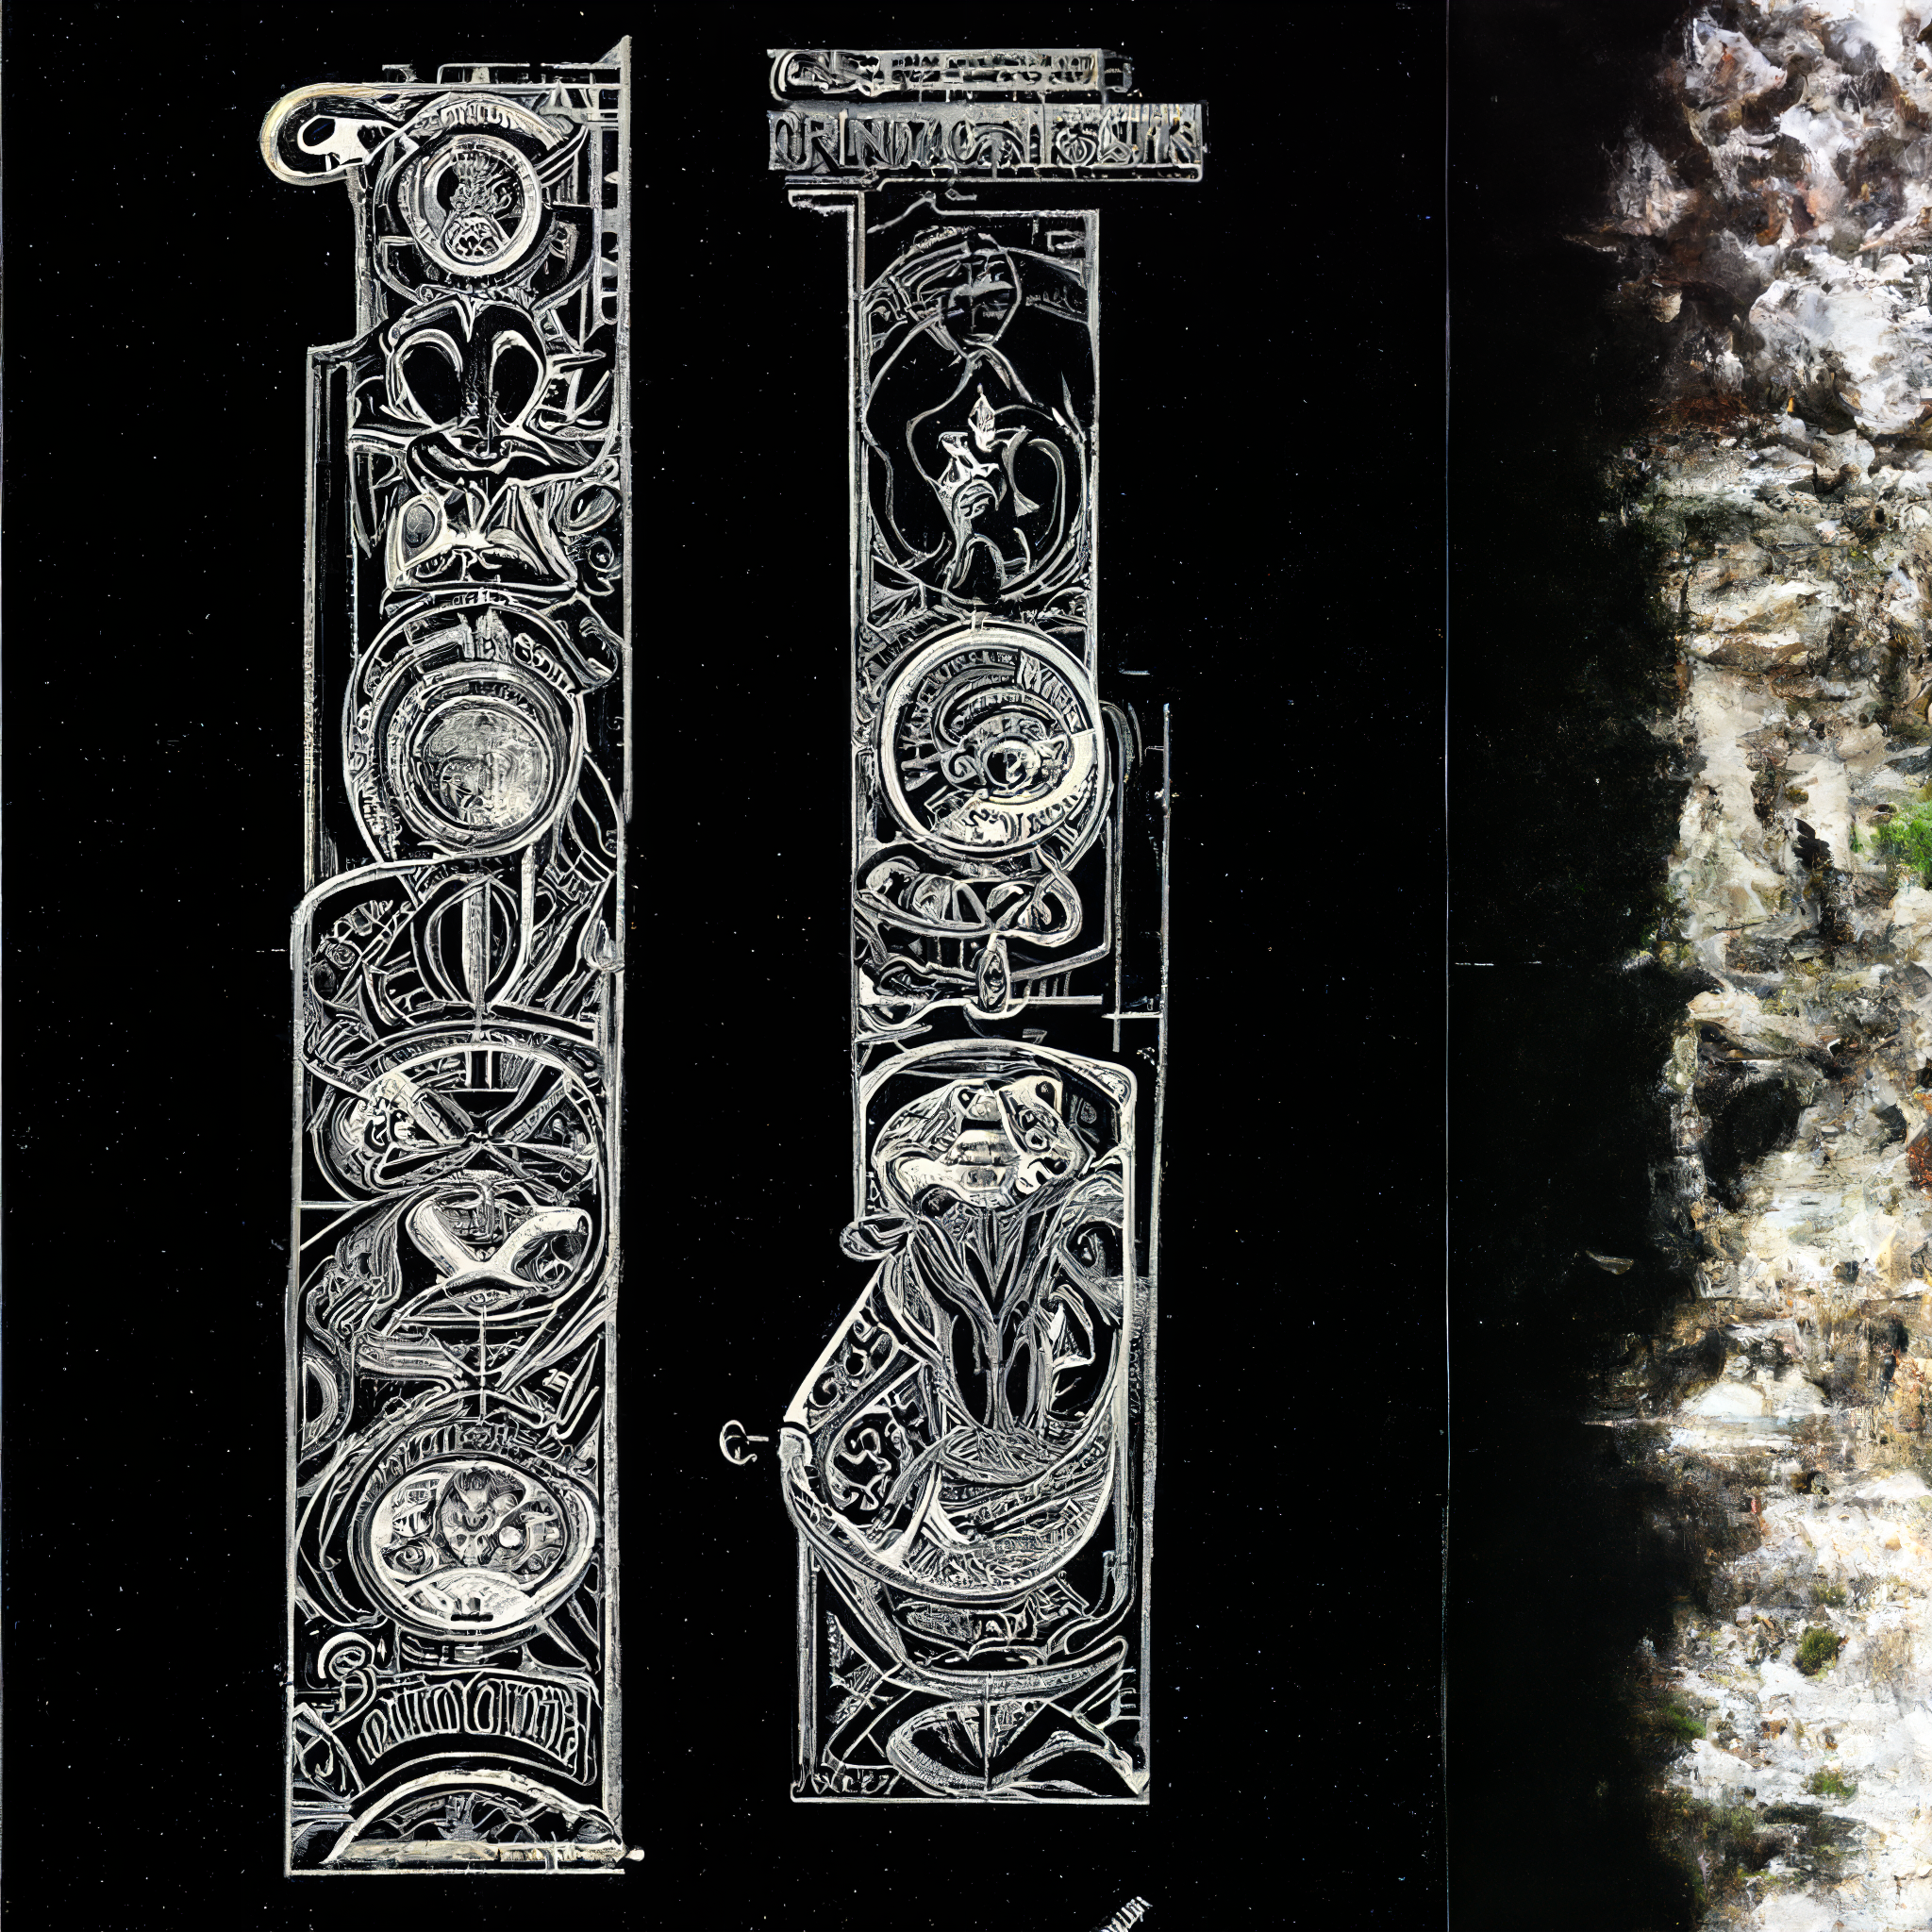

In [6]:
#@title #Run!

overwrite_prior_runs = True #@param {type: 'boolean'}


display.clear_output(wait=True)
gc.collect()
torch.cuda.empty_cache()
filepath = '/home/lleonard/dev/perso/clip_generators/clip_generators/bots/res/discord_out_diffusion/2022_01_05/2022-01-05T01:52:13.403241_Malka#9644_The tarot card of Moon. Art Deco style./out.png'
print(f'Running {filepath}')

im_og = Image.open(filepath)
width_og, height_og = im_og.size

#Downsample Pre
if pre_downsample == '1/2':
    downsample_rate = 2
elif pre_downsample == '1/4':
    downsample_rate = 4
else:
    downsample_rate = 1

width_downsampled_pre = width_og//downsample_rate
height_downsampled_pre = height_og//downsample_rate
if downsample_rate != 1:
    print(f'Downsampling from [{width_og}, {height_og}] to [{width_downsampled_pre}, {height_downsampled_pre}]')
im_og = im_og.resize((width_downsampled_pre, height_downsampled_pre), Image.LANCZOS)
im_og.save('/tmp/temp.png')
filepath = '/tmp/temp.png'

logs = run(model["model"], filepath, diffMode, diffusion_steps, eta)

sample = logs["sample"]
sample = sample.detach().cpu()
sample = torch.clamp(sample, -1., 1.)
sample = (sample + 1.) / 2. * 255
sample = sample.numpy().astype(np.uint8)
sample = np.transpose(sample, (0, 2, 3, 1))
print(sample.shape)
a = Image.fromarray(sample[0])

#Downsample Post
if post_downsample == '1/2':
    downsample_rate = 2
elif post_downsample == '1/4':
    downsample_rate = 4
else:
    downsample_rate = 1

width, height = a.size
width_downsampled_post = width//downsample_rate
height_downsampled_post = height//downsample_rate

if downsample_method == 'Lanczos':
    aliasing = Image.LANCZOS
else:
    aliasing = Image.NEAREST

if downsample_rate != 1:
    print(f'Downsampling from [{width}, {height}] to [{width_downsampled_post}, {height_downsampled_post}]')
    a = a.resize((width_downsampled_post, height_downsampled_post), aliasing)
elif post_downsample == 'Original Size':
    print(f'Downsampling from [{width}, {height}] to Original Size [{width_og}, {height_og}]')
    a = a.resize((width_og, height_og), aliasing)

display.display(a)
a.save('output.png')